# Westeros Tutorial - Introduction to the MESSAGEix framework: Creating a baseline scenario 

**Integrated Assessment Modeling for the 21st Century**

_This tutorial is based on a presentation by Matthew Gidden ([@gidden](https://github.com/gidden)) for a summer school at the the **Centre National de la Recherche Scientifique (CNRS)** on *Integrated Assessment Modeling* in June 2018; and has been extended by members of the MESSAGE*ix* team._

## Scope of this tutorial: building a simple energy system model

The goal of this tutorial is to build a simple energy model using *MESSAGEix* with minimal features that can be expanded in future tutorials.  

We will build the model component by component, focusing on both the **how** (code implementation) and **why** (mathematical formulation).

## Online documentation

The IIASA ECE program maintains extensive documentation for MESSAGE*ix* at [**docs.messageix.org**](https://docs.messageix.org).
 
In this documentation you will find:

- A [“Getting started”](https://docs.messageix.org/en/stable/#getting-started) section, including:
  - How to [**install MESSAGE*ix***](https://docs.messageix.org/en/stable/install.html). You **must** install MESSAGE*ix* in order to run this tutorial.
  - Information about [**required knowledge and skills**](https://docs.messageix.org/en/stable/prereqs.html) for using MESSAGE*ix*. From these, this tutorial assumes you at least know:
    - how to call Python functions via [keyword arguments](https://docs.python.org/3/tutorial/controlflow.html#keyword-arguments);
    - about [pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) and its basic data structures, e.g. `pandas.DataFrame`; and
    - the [`message_ix.make_df()`](https://docs.messageix.org/en/stable/api.html#message_ix.util.make_df) utility function.
  - How to [download and run these tutorial notebooks](https://docs.messageix.org/en/stable/tutorials.html).
    This page also gives a **recommended order** for the remaining Westeros tutorials, for both beginner and more advanced users.
- [**User guidelines** and a notice](https://docs.messageix.org/en/stable/notice.html), to read if you intend to publish research about new models created using MESSAGE*ix*.
- much, much more!

<img src='_static/doc_page.png'>

## A stylized reference energy system model for Westeros

This tutorial is based on the country of Westeros from the TV show "Game of Thrones".

<img src='_static/baseline_res.png' width='900'>

## MESSAGEix: the mathematical paradigm

At its core, *MESSAGEix* is an optimization problem:

> $\min \quad ~c^T \cdot X$  
> $~s.t. \quad a \cdot X \leq b$

More explicitly, the model...
- optimizes an **objective function**, nominally minimizing total **system costs**
- under a system of **constraints** (inequalities or equality conditions)

The mathematical implementation includes a number of features that make it particularly geared towards the modelling of *energy-water-land systems* in the context of *climate change mitigation and sustainable development*.

Throughout this document, the mathematical formulation follows the convention that
- decision **VARIABLES** ($X$) are capitalized
- input **parameters** ($a$, $b$) are lower case

## MESSAGEix: connected to the *ix modeling platform (ixmp)*

The *modeling platform for integrated and cross-cutting analysis* (ixmp) provides a powerful framework for working with scenarios, including a database infrastucture for data version control and interfaces to scientific programming languages.

<img src='_static/message_ixmp.png' width='700'>

## Ready, steady, go!

The *MESSAGEix* model is built using the `ixmp` `Platform`. The `Platform` is your connection to a database for storing model input data and scenario results.

In [1]:
import ixmp

mp = ixmp.Platform("local")

Once connected, we create a new `Scenario` to build our model. A `Scenario` instance will contain all the model input data and results.

In [2]:
import message_ix

scenario = message_ix.Scenario(
    mp, model="Westeros Electrified", scenario="baseline", version="new"
)

## Model Structure

We start by defining basic characteristics of the model, including time, space, and the energy system structure.

The model horizon will span 3 decades (690-720). Let's assume that we're far in the future after the events of A Song of Ice and Fire (which occur ~300 years after Aegon the conqueror).

| Math Notation | Model Meaning                |
|:--------------|:-----------------------------|
| $y \in Y^H$   | time periods in history      |
| $y \in Y^M$   | time periods in model horizon|

In [3]:
history = [690]
model_horizon = [700, 710, 720]
scenario.add_horizon(year=history + model_horizon, firstmodelyear=model_horizon[0])

Our model will have a single `"node"`, i.e., its spatial dimension.


| Math Notation | Model Meaning|
|:--------------|:-------------|
| $n \in N$     | node         |

In [4]:
country = "Westeros"
scenario.add_spatial_sets({"country": country})

And we fill in the energy system's `"commodity"`, `"level"`, `"technology"`, and `"mode"` (i.e., modes of operation of technologies). This information defines how certain technologies operate. 


| Math Notation | Model Meaning|
|:--------------|:-------------|
| $c \in C$     | commodity    |
| $l \in L$     | level        |
| $t \in T$     | technology   |
| $m \in M$     | mode         |

In [5]:
scenario.add_set("commodity", ["electricity", "light"])
scenario.add_set("level", ["secondary", "final", "useful"])
scenario.add_set("technology", ["coal_ppl", "wind_ppl", "grid", "bulb"])
scenario.add_set("mode", "standard")

## Supply and Demand (or Balancing Commodities)

The fundamental premise of the model is to satisfy demand for energy (services).
To first order, demand for services like electricity tracks with economic productivity (GDP).
We define a GDP profile similar to first-world GDP growth from [1900-1930](https://en.wikipedia.org/wiki/List_of_regions_by_past_GDP):

<Axes: title={'center': 'GDP profile'}, xlabel='Time'>

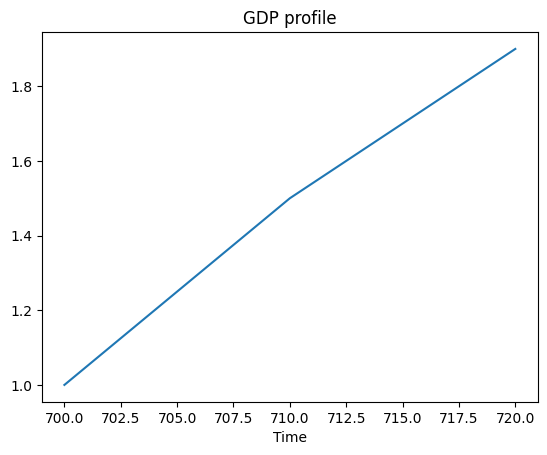

In [6]:
import pandas as pd

gdp_profile = pd.Series([1.0, 1.5, 1.9], index=pd.Index(model_horizon, name="Time"))
gdp_profile.plot(title="GDP profile")

The `COMMODITY_BALANCE_GT` and `COMMODITY_BALANCE_LT` equations ensure that `"demand"` for each `"commodity"` is met at each `"level"` in the energy system.
The equation is copied below in this tutorial notebook, but every model equation is available for reference in
the [Mathematical formulation](https://docs.messageix.org/en/stable/model/MESSAGE/model_core.html) section of the *MESSAGEix* documentation.

$\sum_{\substack{n^L,t,m \\ y^V \leq y}} \mathrm{output}_{n^L,t,y^V,y,m,n,c,l} \cdot \mathrm{ACT}_{n^L,t,y^V,y,m}$
$- \sum_{\substack{n^L,t,m, \\ y^V \leq y}} \mathrm{input}_{n^L,t,y^V,y,m,n,c,l} \cdot \mathrm{ACT}_{n^L,t,m,y}$  
$\geq \mathrm{demand}_{n,c,l,y} \quad \forall \ l \in L$

While `"demand"` must be met, supply can *exceed* demand allowing the model to plan for meeting demand in future periods by storing storable commodities.


First we establish demand. Let's assume

- 40 million people in [300 AC](https://atlasoficeandfireblog.wordpress.com/2016/03/06/the-population-of-the-seven-kingdoms/)
- similar population growth to Earth in the same time frame [(~factor of 12)](https://en.wikipedia.org/wiki/World_population_estimates)
- a per capita demand for electricity of 1000 kWh
- and 8760 hours in a year (of course!)

Then we can add the demand parameter

Note present day: [~72000 GWh in Austria](https://www.iea.org/statistics/?country=AUSTRIA&year=2016&category=Energy%20consumption&indicator=undefined&mode=chart&dataTable=INDICATORS) with population [~8.7M](http://www.austria.org/population/) which is ~8300 kWh per capita

In [7]:
demand_per_year = 40 * 12 * 1000 / 8760
light_demand = pd.DataFrame(
    {
        "node": country,
        "commodity": "light",
        "level": "useful",
        "year": model_horizon,
        "time": "year",
        "value": (demand_per_year * gdp_profile).round(),
        "unit": "GWa",
    }
)

`light_demand` illustrates the data format for *MESSAGEix* parameters. It is a `pandas.DataFrame` containing three types of information in a specific format:

- A `value` column containing the numerical values for this parameter.
- A `unit` column.
- Other columns (`"node"`, `"commodity"`, `"level"`, `"time"`) that indicate the key to which each value applies.

In [8]:
light_demand

,node,commodity,level,year,time,value,unit
Time,,,,,,,
700,Westeros,light,useful,700,year,55.0,GWa
710,Westeros,light,useful,710,year,82.0,GWa
720,Westeros,light,useful,720,year,104.0,GWa


In [9]:
# We use `add_par` for adding data to a MESSAGEix parameter
scenario.add_par("demand", light_demand)

### Notice: Treatment of Units
MESSAGEix mathematical formulation is agnostic towards the entries of "unit". This means the values specified in different parameters, e.g., for capacity or activity, are not checked for their units. Hence, the user must make sure the values are consistent in terms of their units across different parameters. For convenience, we use the unit of "GW" for capacity- and "GWa" (Giga-Watt-annum) for activity-related parameters in this tutorial.

### Specifying Technical Lifetime
Before defining the reference energy system structure, i.e., the connection between technologies, commodities, and levels, we define the `technical_lifetime` of technologies. This is needed for two main purposes:
- to define the combination of vintage and activity years for each technology (see the parameterization of `input` and `output` below).
- in order to properly manage deployed capacity and related costs via the **capacity maintenance** constraint:

$\mathrm{CAP}_{n,t,y^V,y} \leq \mathrm{remaining\_capacity}_{n,t,y^V,y} \cdot \mathrm{value} \quad \forall \quad t \in T^{INV}$

where `value` can take different forms depending on what time period is considered:

| Value                                               | Condition                                           |
|:----------------------------------------------------|:----------------------------------------------------|
| $\Delta_y \mathrm{historical\_new\_capacity}_{n,t,y^V}$ | $y$ is first model period                           |
| $\Delta_y \mathrm{CAP\_NEW}_{n,t,y^V}$                 | $y = y^V$                                           |
| $\mathrm{CAP}_{n,t,y^V,y-1}$                          | $0 < y - y^V < \mathrm{technical\_lifetime}_{n,t,y^V}$ |


$\mathrm{CAP\_NEW}_{n,t,y^V}$ is the newly installed capacity in one year, whereas 
$\mathrm{CAP}_{n,t,y^V,y-1}$ is the amount installed at the end of a (usually multi-year) period.

Here, we import a utility function called `make_df`, which can be used to wrap the input data into dataframes that can be saved in model parameters.

In [10]:
from message_ix import make_df

# Define technical lifetime in years
lifetime = {
    "coal_ppl": 20,
    "wind_ppl": 20,
    "bulb": 1,
    "grid": 30,
}

for tec, val in lifetime.items():
    df = make_df(
        "technical_lifetime",
        node_loc=country,
        year_vtg=history + model_horizon,
        unit="y",
        technology=tec,
        value=val,
    )
    scenario.add_par("technical_lifetime", df)

In [11]:
# Let's see the content
scenario.par("technical_lifetime")

,node_loc,technology,year_vtg,value,unit
0,Westeros,coal_ppl,690,20.0,y
1,Westeros,coal_ppl,700,20.0,y
2,Westeros,coal_ppl,710,20.0,y
3,Westeros,coal_ppl,720,20.0,y
4,Westeros,wind_ppl,690,20.0,y
5,Westeros,wind_ppl,700,20.0,y
6,Westeros,wind_ppl,710,20.0,y
7,Westeros,wind_ppl,720,20.0,y
8,Westeros,bulb,690,1.0,y
9,Westeros,bulb,700,1.0,y


In order to define the input and output commodites of each technology, we define some common keys.

- **Input** quantities require `_origin` keys that specify where the inputs are *received from*.
- **Output** quantities require `_dest` keys that specify where the outputs are *transferred to*.

Working backwards along the Reference Energy System, we can add connections for the `"bulb"`. A light bulb…

- receives `"input"` in the form of the `"electricity"` `commodity` at the `"final"` energy `level`, and
- `"output"`s the `commodity` `"light"` at the `"useful"` energy `level`.

The `value` in the input and output parameter is used to represent the efficiency of a technology (efficiency = output/input).
For example, input of 1.0 and output of 1.0 for a technology shows that the efficiency of that technology is 100% in converting
the input commodity to the output commodity.

In [12]:
year_df = scenario.vintage_and_active_years((country, "bulb"), in_horizon=False)
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]

# Some common values to be used for both the "input" and "output" parameters
base = dict(
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    technology="bulb",
    mode="standard",
    time="year",
    unit="-",
)

# Use the message_ix utility function make_df() to create a base data frame for
# different "input" parameter values
base_input = make_df("input", **base, node_origin=country, time_origin="year")

# Create a base data frame for different "output" parameter values
base_output = make_df("output", **base, node_dest=country, time_dest="year")

In [13]:
# Extend `base_output` by filling in some of the other columns, using the
# pandas.DataFrame.assign() method
bulb_out = base_output.assign(commodity="light", level="useful", value=1.0)
scenario.add_par("output", bulb_out)

bulb_in = base_input.assign(commodity="electricity", level="final", value=1.0)
scenario.add_par("input", bulb_in)

If you don't know the dimensions for a specific parameter—in other words, which keyword arguments you need to pass to `make_df()`, you can use `Scenario.idx_names()`:

In [14]:
scenario.idx_names("input")

['node_loc',
 'technology',
 'year_vtg',
 'year_act',
 'mode',
 'node_origin',
 'commodity',
 'level',
 'time',
 'time_origin']

Next, we parameterize the electrical `"grid"`, which…

- receives electricity at the `"secondary"` energy level.
- also outputs electricity, but at the `"final"` energy level (to be used by the light bulb).

Because the grid has transmission losses, only 90% of the input electricity is available as output. This means for each unit of output electricity from the grid, there should be 1/0.9 (the reverse of efficiency), i.e., 1.1111 unit of input electricity. 

In [15]:
grid_efficiency = 0.9
year_df = scenario.vintage_and_active_years((country, "grid"), in_horizon=False)
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]

base.update(
    year_vtg=vintage_years,
    year_act=act_years,
    technology="grid",
    commodity="electricity",
    level="final",
    value=1.0,
)
grid_out = make_df("output", **base, node_dest=country, time_dest="year")
scenario.add_par("output", grid_out)

base.update(commodity="electricity", level="secondary", value=1.0 / grid_efficiency)
grid_in = make_df("input", **base, node_origin=country, time_origin="year")
scenario.add_par("input", grid_in)

And finally, our power plants. The model does not include the fossil resources used as `"input"` for coal plants; however, costs of coal extraction are included in the parameter `var_cost`, which is defined later with other cost-related parameters.

In [16]:
year_df = scenario.vintage_and_active_years((country, "coal_ppl"), in_horizon=False)
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]

base.update(
    year_vtg=vintage_years,
    year_act=act_years,
    technology="coal_ppl",
    commodity="electricity",
    level="secondary",
    value=1.0,
)
coal_out = make_df("output", **base, node_dest=country, time_dest="year")
scenario.add_par("output", coal_out)

year_df = scenario.vintage_and_active_years((country, "wind_ppl"), in_horizon=False)
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
base.update(
    year_vtg=vintage_years,
    year_act=act_years,
    technology="wind_ppl",
    commodity="electricity",
    level="secondary",
    value=1.0,
)
wind_out = make_df("output", **base, node_dest=country, time_dest="year")
scenario.add_par("output", wind_out)

## Operational Constraints and Parameters

The model has a number of "reality" constraints, which relate built *capacity* (`CAP`) to available power, or the *activity* (`ACT`) of that technology.

The **capacity constraint** limits the activity of a technology to the installed capacity multiplied by a capacity factor. The capacity factor is the fraction of installed capacity that can be active in a certain period (here the sub-annual time step *h*).

$$\sum_{m} \mathrm{ACT}_{n,t,y^V,y,m,h}
    \leq \mathrm{duration\_time}_{h} \cdot \mathrm{capacity\_factor}_{n,t,y^V,y,h} \cdot \mathrm{CAP}_{n,t,y^V,y}
    \quad t \ \in \ T^{INV}$$


This requires us to provide the `"capacity_factor"` for each technology. Here, we call `make_df()` and `add_par()` in a loop to execute similar code for three technologies:

In [17]:
capacity_factor = {
    "coal_ppl": 1,
    "wind_ppl": 0.36,
    "bulb": 1,
    "grid": 1,
}

for tec, val in capacity_factor.items():
    year_df = scenario.vintage_and_active_years((country, tec), in_horizon=False)
    df = make_df(
        "capacity_factor",
        node_loc=country,
        year_vtg=year_df["year_vtg"],
        year_act=year_df["year_act"],
        time="year",
        unit="-",
        technology=tec,
        value=val,
    )
    scenario.add_par("capacity_factor", df)

## Technological Diffusion and Contraction

We know from historical precedent that energy systems can not be transformed instantaneously. Therefore, we use a family of dynamic constraints on activity and capacity. These constraints define the upper and lower limit of the domain of activity and capacity over time based on their value in the previous time step, an initial value, and growth/decline rates.

$\sum_{y^V \leq y,m} \mathrm{ACT}_{n,t,y^V,y,m,h} \leq$  
$\mathrm{initial\_activity\_up}_{n,t,y,h}
        \cdot \frac{ \Big( 1 + \mathrm{growth\_activity\_up}_{n,t,y,h} \Big)^{|y|} - 1 }
                   { \mathrm{growth\_activity\_up}_{n,t,y,h} }+ \Big( 1 + \mathrm{growth\_activity\_up}_{n,t,y,h} \Big)^{|y|} \cdot \Big( \sum_{y^V \leq y-1,m} \mathrm{ACT}_{n,t,y^V,y-1,m,h} + \sum_{m} \mathrm{historical\_activity}_{n,t,y-1,m,h}\Big)$  

This example limits the ability for technologies to **grow**. To do so, we need to provide `"growth_activity_up"` values for each technology that we want to model as being diffusion constrained. Here, we set this constraint at 10% per year.

In [18]:
growth_technologies = [
    "coal_ppl",
    "wind_ppl",
]

for tec in growth_technologies:
    df = make_df(
        "growth_activity_up",
        node_loc=country,
        year_act=model_horizon,
        time="year",
        unit="-",
        technology=tec,
        value=0.1,
    )
    scenario.add_par("growth_activity_up", df)

## Defining an Energy Mix (Model Calibration)

To model the transition of an energy system, one must start with the existing system which is defined by the parameters `"historical_activity"` and `"historical_new_capacity"`. These parameters define the energy mix before the model horizon. 

Defining both parameters is essential to limit the capacity in the first model period. Without these, the model can (and will!) make a totally free (unconstrained) choice of what mix of technologies are used to meet demand in the first model period, perhaps choosing some ahistorical values. With these parameters defined, the MESSAGE formulation ensures a smooth transition from historical years to model periods.

We begin by defining a few key values:

- how much useful energy was needed
- how much final energy was generated
- and the mix for different technologies

In [19]:
historic_demand = 0.5 * demand_per_year
historic_generation = historic_demand / grid_efficiency
coal_fraction = 0.6

Then, we can define the **activity** in the historic period.

In [20]:
old_activity = {
    "coal_ppl": coal_fraction * historic_generation,
    "wind_ppl": (1 - coal_fraction) * historic_generation,
    "grid": historic_generation,
}

for tec, val in old_activity.items():
    df = make_df(
        "historical_activity",
        node_loc=country,
        year_act=history,
        mode="standard",
        time="year",
        unit="GWa",
        technology=tec,
        value=val,
    )
    scenario.add_par("historical_activity", df)

And the **new capacity** in the historic period.

Remember $$\sum_{m} \mathrm{ACT}_{n,t,y^V,y,m,h}
    \leq \mathrm{duration\_time}_{h} \cdot \mathrm{capacity\_factor}_{n,t,y^V,y,h} \cdot \mathrm{CAP}_{n,t,y^V,y}
    \quad t \ \in \ T^{INV}$$

and 

$$ \mathrm{CAP}_{n,t,y^V,y} = \mathrm{CAP\_NEW}_{n,t,y^V} \cdot \mathrm{duration\_period}_{y} $$

Since we want to get the activity during the whole historic year 690 and not of a sub-annual time slice, e.g., only spring (`duration_time` = 0.25), the `duration_time` is 1.  

To get the new capacity in the historic period, the capacity, which needs to get built **per year** to meet the demand in the year 690, we resolve to the following:

$$ \mathrm{CAP\_NEW}_{n,t,y^V} = \frac{\sum_{m} \mathrm{ACT}_{n,t,y^V,y,m,h}}{\mathrm{duration\_time}_{h} \cdot \mathrm{duration\_period}_{y}  \cdot \mathrm{capacity\_factor}_{n,t,y^V,y,h}} $$ 

The `duration_period` of the first period (historic period) is set to the value that appears most frequently. Here every period has 10 years, so the `duration_period` of the first period is likewise 10 years.

In [21]:
mp.add_unit("GW/y")
for tec in old_activity:
    value = old_activity[tec] / (1 * 10 * capacity_factor[tec])
    df = make_df(
        "historical_new_capacity",
        node_loc=country,
        year_vtg=history,
        unit="GW/y",
        technology=tec,
        value=value,
    )
    scenario.add_par("historical_new_capacity", df)

## Objective Function

The objective function drives the purpose of the optimization. Do we wish to seek the maximum utility of the social planner, minimize carbon emissions, or something else? Classical IAMs seek to minimize total discounted system cost over space and time. 

$$\min \sum_{n,y \in Y^{M}} \mathrm{interestrate}_{y} \cdot \mathrm{COST\_NODAL}_{n,y}$$


First, let's add the interest rate parameter.

In [22]:
scenario.add_par("interestrate", model_horizon, value=0.05, unit="-")

`COST_NODAL` is comprised of a variety of costs related to the use of different technologies.

### Investment Costs

Capital, or investment, costs are invoked whenever a new plant or unit is built

$$\mathrm{inv\_cost}_{n,t,y} \cdot \mathrm{construction\_time\_factor}_{n,t,y} \cdot \mathrm{CAP\_NEW}_{n,t,y}$$

In [23]:
# Add a new unit for ixmp to recognize as valid
mp.add_unit("USD/kW")

# in $ / kW (specific investment cost)
costs = {
    "coal_ppl": 500,
    "wind_ppl": 1500,
    "bulb": 5,
    "grid": 800,
}

for tec, val in costs.items():
    df = make_df(
        "inv_cost",
        node_loc=country,
        year_vtg=model_horizon,
        unit="USD/kW",
        technology=tec,
        value=val,
    )
    scenario.add_par("inv_cost", df)

### Fixed O&M Costs

Fixed cost are only relevant as long as the capacity is active. This formulation allows to include the potential cost savings from early retirement of installed capacity.

$$\sum_{y^V \leq y} \mathrm{fix\_cost}_{n,t,y^V,y} \cdot \mathrm{CAP}_{n,t,y^V,y}$$

In [24]:
# in $ / kW / year (every year a fixed quantity is destinated to cover part of the O&M
# costs based on the size of the plant, e.g. lighting, labor, scheduled maintenance,
# etc.)

costs = {
    "coal_ppl": 30,
    "wind_ppl": 10,
    "grid": 16,
}

for tec, val in costs.items():
    year_df = scenario.vintage_and_active_years((country, tec), in_horizon=False)
    df = make_df(
        "fix_cost",
        node_loc=country,
        year_vtg=year_df["year_vtg"],
        year_act=year_df["year_act"],
        unit="USD/kWa",
        technology=tec,
        value=val,
    )
    scenario.add_par("fix_cost", df)

### Variable O&M Costs

Variable Operation and Maintence costs are associated with the costs of actively running the plant. Thus, they are not applied if a plant is on standby (i.e., constructed, but not currently in use).

$$\sum_{\substack{y^V \leq y \\ m,h}} \mathrm{var\_cost}_{n,t,y^V,y,m,h} \cdot \mathrm{ACT}_{n,t,y^V,y,m,h} $$

In [25]:
# In $ / kWa (costs associated with the degradation of equipment
# when the plant is functioning per unit of energy produced
# kW·year = 8760 kWh. Therefore the costs represents USD per 8760 kWh
# of energy). Do not confuse with fixed O&M units.

costs = {
    "coal_ppl": 30,
}

for tec, val in costs.items():
    year_df = scenario.vintage_and_active_years((country, tec), in_horizon=False)
    df = make_df(
        "var_cost",
        node_loc=country,
        year_vtg=year_df["year_vtg"],
        year_act=year_df["year_act"],
        mode="standard",
        time="year",
        unit="USD/kWa",
        technology=tec,
        value=val,
    )
    scenario.add_par("var_cost", df)

A full model will not only have costs associated with technologies (investment, fixed, variable costs), but also

- resource extraction: $\sum_{c,g} \ \mathrm{resource\_cost}_{n,c,g,y} \cdot \mathrm{EXT}_{n,c,g,y} $
- emissions
- land use (emulator): $\sum_{s} \mathrm{land\_cost}_{n,s,y} \cdot \mathrm{LAND}_{n,s,y}$

## Time to Solve the Model

First, we *commit* the model structure and input data (sets and parameters).
Because we created `scenario` with `version="new"`, the `ixmp` storage backend automatically creates and assigns a new version number.

In [26]:
from message_ix import log

log.info(f"version number before commit(): {scenario.version}")

scenario.commit(comment="basic model of Westeros electrification")

log.info(f"version number after commit(): {scenario.version}")

An `ixmp` database can contain many scenarios, and possibly multiple versions of the same model and scenario name.
These are distinguished by unique version numbers.

To make it easier to retrieve the "correct" version (e.g., the latest one), you can set a specific scenario as the default version to use if the "Westeros Electrified" model is loaded from the `ixmp` database.

In [27]:
scenario.set_as_default()

In [28]:
scenario.solve()

In [29]:
scenario.var("OBJ")["lvl"]

159025.828125

## Plotting Results

Analyzing the results of a scenario after it is solved is called **reporting**.
MESSAGE*ix* includes a flexible and customizable message_ix/tutorial for reporting, but here we wish to focus on the results of our example scenario.
First, we configure `matplotlib` so that images are produced inline. We then use some custom code to set up some simple plots:

In [30]:
%matplotlib inline

In [31]:
from message_ix.report import Reporter
from message_ix.util.tutorial import prepare_plots

# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
rep = Reporter.from_scenario(scenario)

# "prepare_plots" enables several to describe reporting operations, e.g.
# "plot activity", "plot capacity", or "plot prices"
# See message_ix/util/tutorial.py for more information
prepare_plots(rep)

<IPython.core.display.Javascript object>

Now the object `rep` is ready to generate several plots.

(For a detailed introduction to how the `Reporter` works, see `westeros_report.ipynb`.)

### Activity

How much energy is generated in each time period from the different potential sources?

<Axes: title={'center': 'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

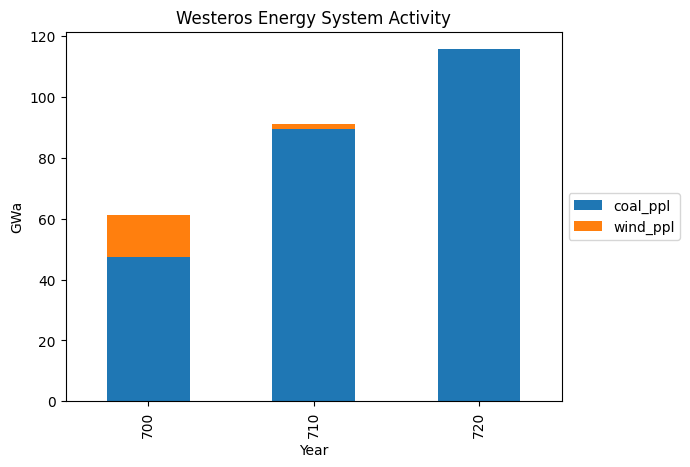

In [32]:
# Only show a subset of technologies in the following plots;
# e.g. exclude "bulb" and "grid"
rep.set_filters(t=["coal_ppl", "wind_ppl"], ya=[700, 710, 720])

# Trigger the calculation and plotting
rep.get("plot activity")

### Capacity

How much capacity of each plant is installed in each period?

<Axes: title={'center': 'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

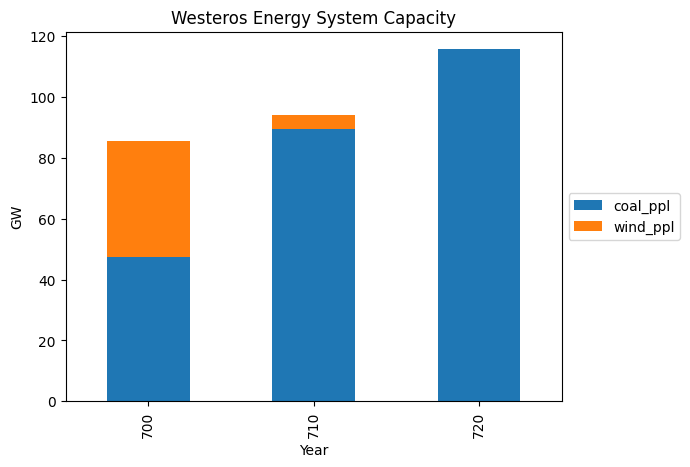

In [33]:
# Create a different plot. The same filters are still active.
rep.get("plot capacity")

### New capacity

How much new capacity is installed in each period? Notice that the new installed capacity requires additional investments.

<Axes: title={'center': 'Westeros Energy System New Capacity'}, xlabel='Year', ylabel='GWa'>

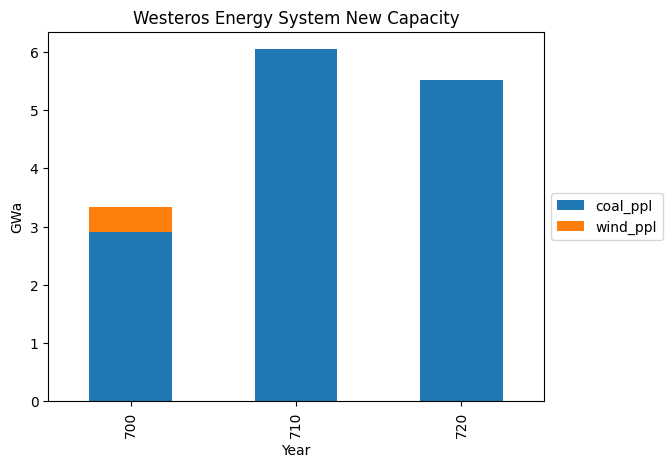

In [34]:
# Create another plot. The same filters are still active.
rep.set_filters(yv=[700, 710, 720])
rep.get("plot new capacity")

### Electricity Price

And how much does the electricity cost? These prices are in fact **shadow prices** taken from the **dual variables** of the model solution.
They reflect the marginal cost of electricity generation (i.e., the additional cost of the system for supplying one more unit of
electricity), which is in fact the marginal cost of the most expensive operating generator.  

Note the price drop when the more expensive technology, i.e., wind, is no longer being invested in by the system.

<Axes: title={'center': 'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

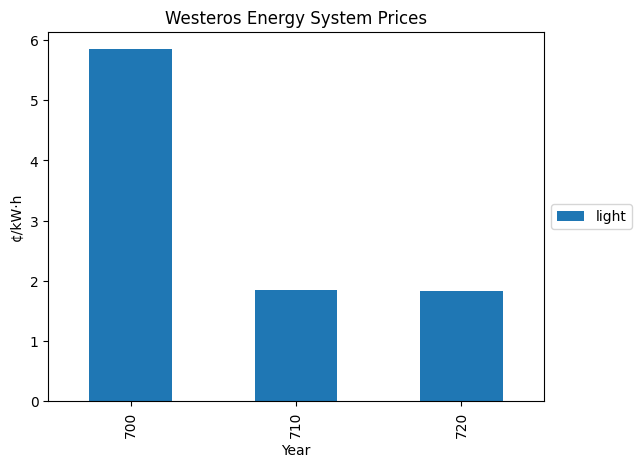

In [35]:
# Replace the technology filters with a commodity filter;
# show only "light" and not e.g. "electricity".
rep.set_filters(c=["light"])

# Create a price plot
rep.get("plot prices")

## Close the connection to the database

When working with local HSQLDB database instances, you cannot connect to one database from multipe Jupyter notebooks (or processes) at the same time.

If you want to easily switch between notebooks with connections to the same `ixmp` database, you need to close the connection in one notebook before initializing the platform using `ixmp.Platform()` in another notebook.

After having closed the database connection, you can reopen it using
```
mp.open_db()
```

In [36]:
mp.close_db()

## Congratulations! 

You have built and run your very first MESSAGE*ix* model. Welcome to the community!

The next tutorials will introduce you to other features of the framework, including energy system constraints, emissions taxes, and other policy options.

Check us out on Github at https://github.com/iiasa/message_ix and share your progress and questions in the [discussion forums](https://github.com/iiasa/message_ix/discussions).